## Driver code comparing output of different preproc software 
- Note: currently using output after atlas-based grouping
- Atlas used: DKT (Freesurfer) DKT-40 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import time


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
#proj_dir = '/Users/nikhil/projects/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
outlier_dir = data_dir + 'outliers/'
results_dir = data_dir + 'results/'

demograph_file = 'ABIDE_Phenotype.csv'
dkt_roi_names = '/DKT/DKT_parcel_map_FS_CIVET.csv'
software_roi_map = '/DKT/Software_ROI_map.csv' # TODO: Need to use this instead parising names everytime.

ants_file = 'ABIDE_ants_thickness_data.csv' #uses modified (mindboggle) dkt atlas with 31 ROIs
civet_file = 'ABIDE_civet2.1_thickness.csv'

fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs60_lh_file = 'DKTatlas_thickness_lh.csv' #'lh.aparc.thickness.table.test1' #'aparc_lh_thickness_table.txt' #'lh.aparc.thickness.table.test1'
fs60_rh_file = 'DKTatlas_thickness_rh.csv' #'rh.aparc.thickness.table.test1' #'aparc_rh_thickness_table.txt' #'rh.aparc.thickness.table.test1'

manual_outlier_file = 'master_QC_table.csv'
software_outlier_file = 'pipeline_outlier_data.csv'

### Workflow configs

In [3]:
software_list = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0']
covar_list = ['SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']
qc_list = ['No_QC','manual_lenient','manual_stringent','auto']

data_label = 'software' # dataset label used to identify after merge

### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Load data

In [5]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# ROI names to match FS and CIVET parcels
dkt_roi_map = pd.read_csv(data_dir + dkt_roi_names)

print('loading available datasets...\n')

data_dict = {}
for software in software_list:
    # CIVET 2.1
    if software == 'CIVET':
        civet_data = pd.read_csv(data_dir + civet_file, dtype={subject_ID_col: str})
        print('shape of civet data {}'.format(civet_data.shape))
        data_std = standardize_civet_data(civet_data, subject_ID_col, dkt_roi_map)

    # ANTs
    if software == 'ANTs':
        ants_data = pd.read_csv(data_dir + ants_file, header=2)
        print('shape of ants data {}'.format(ants_data.shape))
        data_std = standardize_ants_data(ants_data, subject_ID_col)

    # FS    
    if software == 'FS5.1':
        fs51_data = pd.read_csv(data_dir + fs51_file)
        print('shape of fs51 data {}'.format(fs51_data.shape))
        data_std = standardize_fs_data(fs51_data, subject_ID_col)
        
    if software == 'FS5.3':
        fs53_data = pd.read_csv(data_dir + fs53_file)
        print('shape of fs53 data {}'.format(fs53_data.shape))
        data_std = standardize_fs_data(fs53_data, subject_ID_col)

    if software == 'FS6.0':
        fs60_lh_data = pd.read_csv(fs60_dir + fs60_lh_file, delim_whitespace=True)
        fs60_rh_data = pd.read_csv(fs60_dir + fs60_rh_file, delim_whitespace=True)
        print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))
        data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col,aparc='aparc.DKTatlas')
    
    print('  shape of stdized {} data {}\n'.format(software, data_std.shape))
    data_dict[software] = data_std

loading available datasets...

shape of ants data (1101, 99)
  shape of stdized ANTs data (1101, 90)

shape of civet data (899, 65)
  shape of stdized CIVET data (899, 65)

shape of fs51 data (1112, 74)
  shape of stdized FS5.1 data (1112, 74)

shape of fs53 data (976, 74)
  shape of stdized FS5.3 data (976, 74)

shape of fs60 data l: (1047, 33), r: (1047, 34)
shape of left and right merge fs6.0 df (1047, 66)
  shape of stdized FS6.0 data (1047, 66)



### Create master dataframe

In [6]:
na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 

master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action, data_label)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col] + covar_list].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls) 
# Replace to (2 with 0 for statsmodels to define 1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}, ROIs {}'.format(len(common_subs), 
                                                       master_df_raw[master_df_raw[data_label]=='fs60']['DX_GROUP'].value_counts().to_dict(),
                                                       len(common_roi_cols)))


Number of datasets: 5
Finding common subject and columns
dataset : FS5.3
common subs: 976
dataset : CIVET
common subs: 801
dataset : FS6.0
common subs: 779
dataset : FS5.1
common subs: 779
dataset : ANTs
common subs: 778
Number of common subjects and columns: 778, 63

checking FS5.3 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (778, 64)

checking CIVET dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (1556, 64)

checking FS6.0 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (2334, 64)

checking FS5.1 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (3112, 64)

checking ANTs dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape

### Basic demographic distributions


QC type: No_QC

QC type: manual_lenient

Filtering based on QC_maarten. Number subjects before filtering 778
Resultant number of subjects 748

QC type: manual_stringent
Unknow QC type

Filtering based on QC_maarten. Number subjects before filtering 778
Resultant number of subjects 748

QC type: auto

Filtering based on QC_outlier. Number subjects before filtering 778
Resultant number of subjects 685


/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


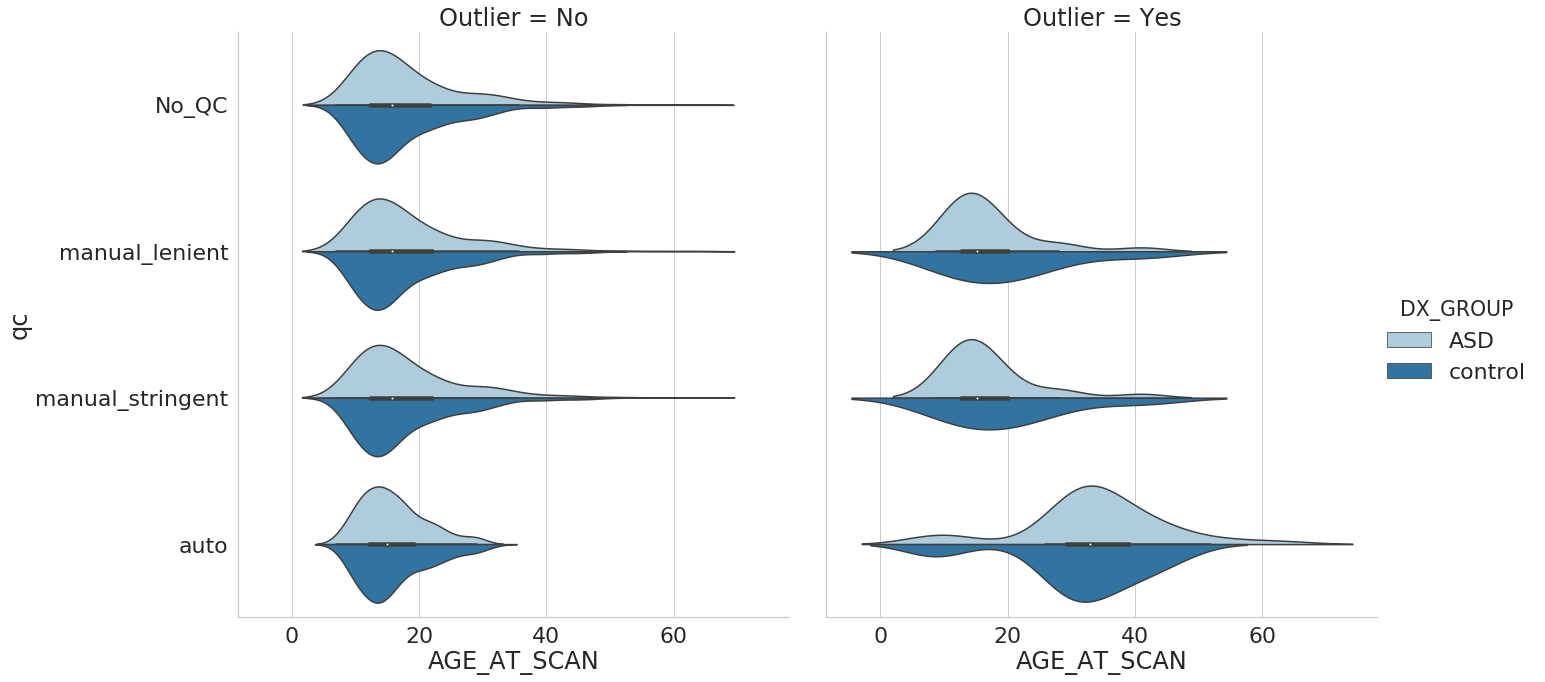

In [7]:
demo_df_concat = pd.DataFrame()

for qc in qc_list:
    print('\nQC type: {}'.format(qc))
    parc_df = master_df_raw[master_df_raw[data_label]=='CIVET'].copy()
    if qc == 'No_QC':        
        filtered_df = parc_df
        
    else:            
        if qc == 'manual_lenient':
            qc_df = pd.read_csv(qc_dir + manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_maarten',[0]) # keep subs
        elif qc == 'manual_stringnent':
            qc_df = pd.read_csv(qc_dir + manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
        elif qc == 'auto':
            qc_df_long = pd.read_csv(outlier_dir + software_outlier_file,dtype={'SubjID': int})
            qc_df = qc_df_long.pivot(index=subject_ID_col,columns='pipeline',values='outlier_ind')
            qc_df.apply(pd.to_numeric)
            #keep only if a subject is not an outlier in any of the software
            qc_df['QC_outlier'] = qc_df[list(qc_df.columns)].sum(axis=1) 
            qc_df[subject_ID_col] = qc_df.index
            qc_criterion = ('QC_outlier',[0])    
        else:
            print('Unknow QC type')

        # Subjects you want to keep based on other crieria for sample size purposes
        external_criterion = None
        filtered_df = filter_data(parc_df, subject_ID_col, qc_df, qc_criterion, external_criterion)
    
    filtered_subs = filtered_df[subject_ID_col].unique()
    
    parc_df['Outlier'] = np.tile('Yes',len(parc_df))
    parc_df.loc[parc_df[subject_ID_col].isin(filtered_subs),'Outlier'] = 'No'
    parc_df['qc'] = np.tile(qc,len(parc_df))
    demo_df_concat = demo_df_concat.append(parc_df[covar_list+['qc','Outlier']])
    
plot_df = demo_df_concat
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
plot_df['SEX'] = plot_df['SEX'].replace({0:'M', 1:'F'})

sns.set(font_scale=2)

with sns.axes_style("whitegrid"):
    sns.catplot(x="AGE_AT_SCAN", y="qc", hue="DX_GROUP", kind="violin", split=True, height=10, aspect=1,
                col='Outlier', palette="Paired", data=plot_df);

### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 
- Ringing subs: ['0050197',0050211','0050049','0051160','0050815','0050418','0050422','0050423','0050309','0050283','0050313','0050323','0051353','0051352','0051334']

In [8]:
# Dictionary allow iterating and QC comparisons later
# Default master_df is without QC

master_df_dict = {}
n_workflow = len(master_df_raw[data_label].unique())
outlier_df = pd.DataFrame(index=master_df_raw[subject_ID_col].unique())
for qc in qc_list:
    if qc == 'No_QC':
        print('No QC applied')
        filtered_df = master_df_raw
        filtered_subs = filtered_df[subject_ID_col].unique()
        print('Resultant number of subjects {}'.format(len(filtered_subs)))
    else:            
        if qc == 'manual_lenient':
            qc_df = pd.read_csv(qc_dir + manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_maarten',[0]) # keep subs
        elif qc == 'manual_stringent':
            qc_df = pd.read_csv(qc_dir + manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
        elif qc == 'auto':
            qc_df_long = pd.read_csv(outlier_dir + software_outlier_file ,dtype={'SubjID': int})
            qc_df = qc_df_long.pivot(index=subject_ID_col,columns='pipeline',values='outlier_ind')
            qc_df.apply(pd.to_numeric)
            #keep only if a subject is not an outlier in any of the software
            qc_df['QC_outlier'] = qc_df[list(qc_df.columns)].sum(axis=1) 
            qc_df[subject_ID_col] = qc_df.index
            qc_criterion = ('QC_outlier',[0])    
        else:
            print('Unknow QC type')

        # Subjects you want to keep based on other crieria for sample size purposes
        external_criterion = {'SITE_ID':3*n_workflow}
        filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
        filtered_subs = filtered_df[subject_ID_col].unique()
        outlier_df[qc] = np.where(outlier_df.index.isin(filtered_subs),0,1)
        
    master_df_dict[qc] = filtered_df

master_df = master_df_dict['No_QC'] # Default

No QC applied
Resultant number of subjects 778

Filtering based on QC_maarten. Number subjects before filtering 778
Resultant number of subjects 748
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects 748

Filtering based on QC_gleb. Number subjects before filtering 778
Resultant number of subjects 204
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID MAX_MUN    15
UCLA_2     15
OLIN       15
PITT        5
Name: SITE_ID, dtype: int64
Resultant number of subjects 194

Filtering based on QC_outlier. Number subjects before filtering 778
Resultant number of subjects 685
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workf

Total number of subjects: 778

outlier overlap
                  manual_lenient  manual_stringent  auto
manual_lenient                30                30     6
manual_stringent              30               584    89
auto                           6                89    95


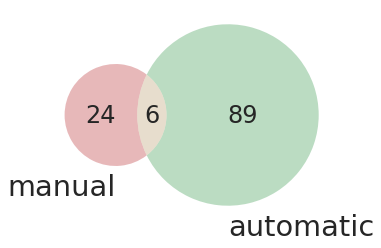

In [9]:
# Outlier comparisons
outlier_overlap = outlier_df.T.dot(outlier_df)
print('Total number of subjects: {}\n'.format(len(outlier_df)))
print('outlier overlap')
print(outlier_overlap)

# Venn diagrams
s1 = set(outlier_df[outlier_df['manual_lenient']==1].index)
s2 = set(outlier_df[outlier_df['manual_stringent']==1].index)
s3 = set(outlier_df[outlier_df['auto']==1].index)
v = venn2([s1,s3],set_labels = ('manual', 'automatic'))
#v = venn3([s1,s2,s3],set_labels = ('manual_maarten', 'manual_gleb', 'auto'))


### Correlation between pipelines

In [12]:
master_df = master_df_dict['auto']

possible_pairs = list(itertools.combinations(data_dict.keys(), 2))
xcorr_pairs_df = pd.DataFrame()
table_df = pd.DataFrame(columns=software_list,index=software_list)
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    for dx in [0,1]:
        df1 = master_df[(master_df[data_label]==pipe1)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        df2 = master_df[(master_df[data_label]==pipe2)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        xcorr_df = cross_correlations(df1,df2,subject_ID_col)
        xcorr_df['{}_pair'.format(data_label)] = np.tile(str('{}-{}'.format(pair[0],pair[1])),len(xcorr_df))
        xcorr_df['DX_GROUP'] = np.tile(dx,len(xcorr_df))
        xcorr_pairs_df = xcorr_pairs_df.append(xcorr_df)
        mean_corr = np.mean(xcorr_df['correlation'].values)
        #print('DX {}, Avg cross correlation between {} & {} = {:4.2f}\n'.format(dx, pipe1,pipe2,mean_corr))
        table_df.loc[pipe1,pipe2] = mean_corr.round(2)
        table_df.loc[pipe2,pipe1] = mean_corr.round(2)

table_df

,ANTs,CIVET,FS5.1,FS5.3,FS6.0
ANTs,NaN,0.39,0.39,0.46,0.41
CIVET,0.39,NaN,0.44,0.48,0.49
FS5.1,0.39,0.44,NaN,0.87,0.83
FS5.3,0.46,0.48,0.87,NaN,0.88
FS6.0,0.41,0.49,0.83,0.88,NaN


Shape of cross-corr df (1240, 4), number of pairs 10


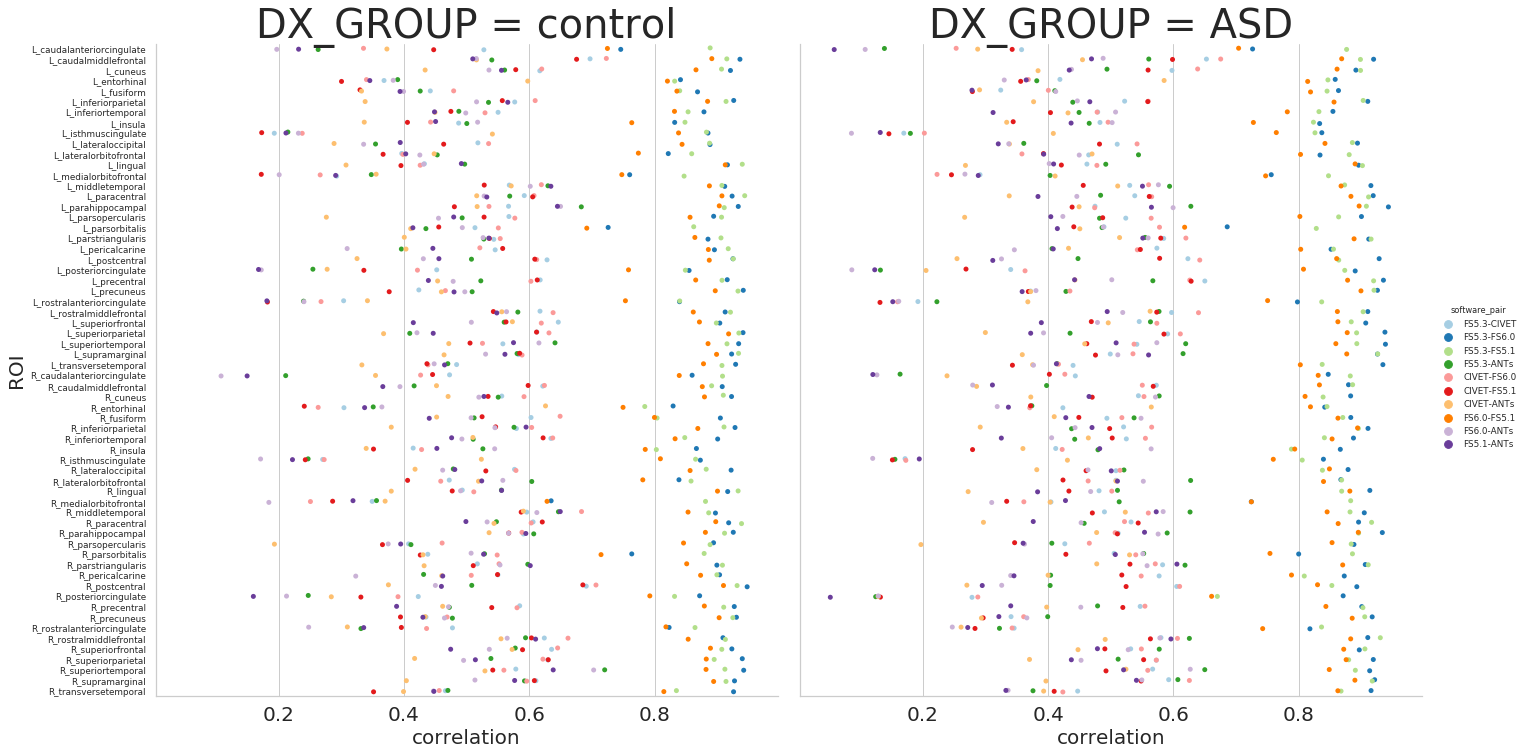

In [13]:
# Plot ROI wise correlations

plot_df = xcorr_pairs_df
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})

print('Shape of cross-corr df {}, number of pairs {}'.format(xcorr_pairs_df.shape, 
                                                             len(xcorr_pairs_df['{}_pair'.format(data_label)].unique())))
roi_order = sorted(list(xcorr_pairs_df['ROI'].unique()))
sns.set(font_scale=0.8)

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='{}_pair'.format(data_label),order=roi_order,palette='Paired',col='DX_GROUP',
                data=plot_df,aspect=1,height=10,kind='strip')
    g.set_xticklabels(fontsize=20)
    g.set_xlabels(fontsize=20)
    g.set_ylabels(fontsize=20)
    g.set_titles(fontsize=40)

### Covariance / Correlation between ROIs

Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)


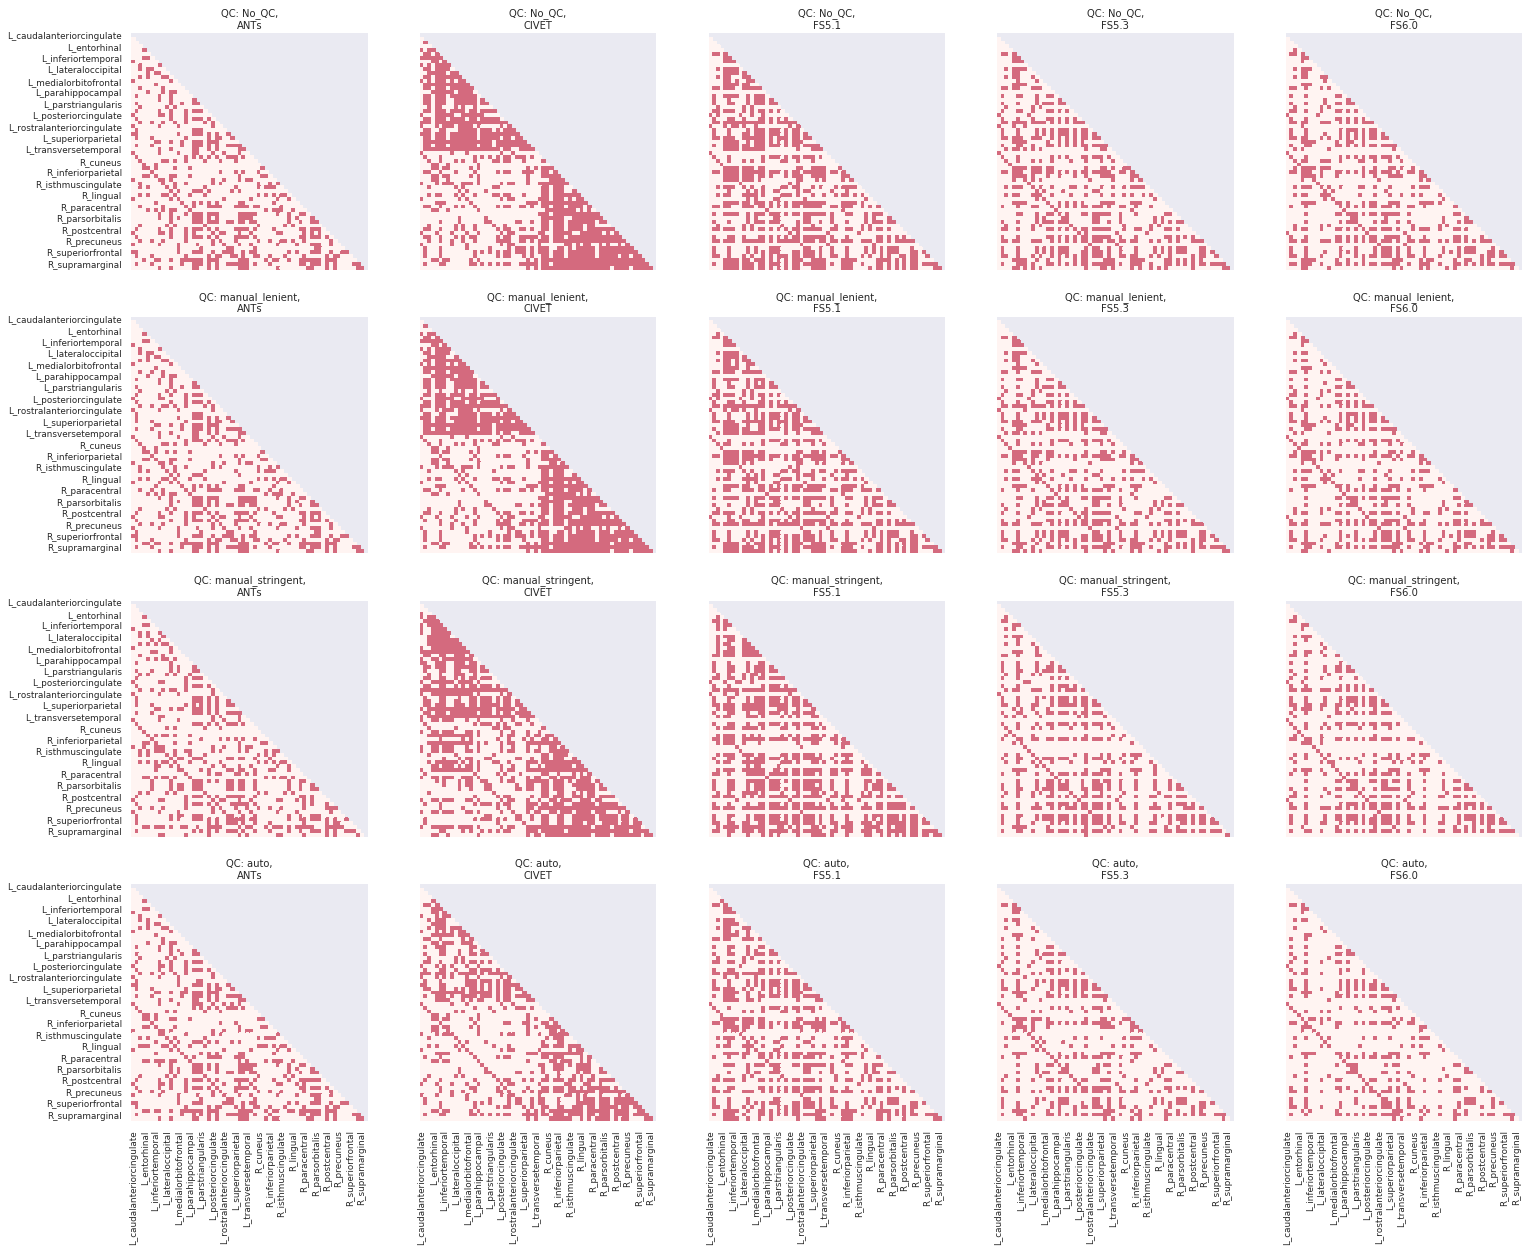

In [14]:
p_thresh= 0.05/(62*62/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

fig,axn = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(25, 20))

p=0
for qc in qc_list:
    master_df = master_df_dict[qc]

    for pipe in software_list:
        df = master_df[master_df[data_label]==pipe][[subject_ID_col]+common_roi_cols]
        df_sorted = df.reindex(sorted(df.columns), axis=1)

        corr = df_sorted.corr()
        df_p_val = calculate_pvalues(df_sorted)
        corr[df_p_val >= p_thresh] = 0
        corr[corr < r_thresh] = 0
        print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

        # Plot
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

        # Generate a custom diverging colormap
        cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

        with sns.axes_style("white"):
            sns.set(font_scale=0.5)
            g = sns.heatmap(corr, mask=mask, square=True, cmap=cmap, ax=axn.flat[p],cbar=False)
            g.set_title('QC: {},\n{}'.format(qc,pipe),fontsize=10)
    #         colorbar = g.collections[0].colorbar
    #         colorbar.set_ticks([0.25,0.75])
    #         colorbar.set_ticklabels(['0', '1'])
    #         g.figure.axes[-1].tick_params(labelsize=20)
    
        p+=1

### Covariance / Correlation between Individuals

Shapes df (683, 63), df_corr (683, 683)


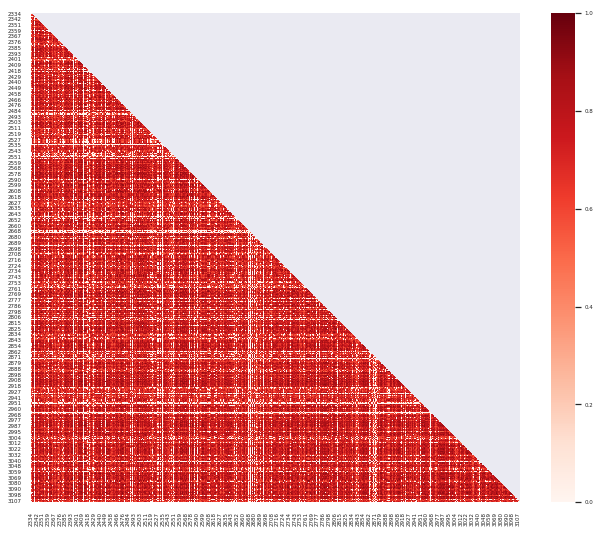

In [36]:
p_thresh= 0.05/(778*778/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

pipe = 'civet'
df = master_df[master_df[data_label]==pipe][[subject_ID_col]+common_roi_cols]
df_sorted = df.reindex(sorted(df.columns), axis=1)

corr = df_sorted[common_roi_cols].transpose().corr()
df_p_val = calculate_pvalues(df_sorted)
corr[df_p_val >= p_thresh] = 0
corr[corr < r_thresh] = 0
print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

# Plot
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'Reds'#sns.diverging_palette(220, 10, as_cmap=True)


with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True)


### TSNE

In [22]:
from sklearn.manifold import TSNE
qc = 'auto'
master_df = master_df_dict[qc]

X = master_df[common_roi_cols].values
print(master_df.shape)

X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(3415, 68)


(3415, 2)

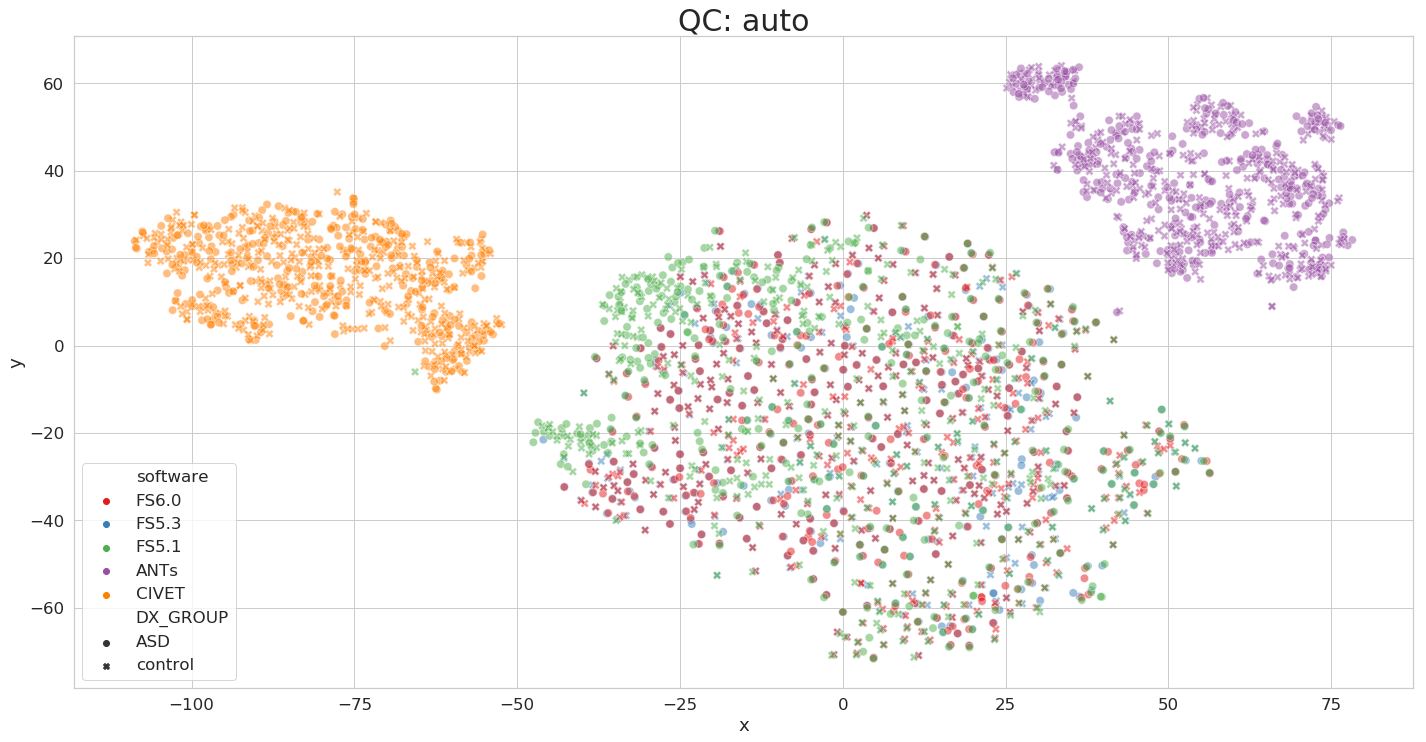

In [23]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df[data_label] = master_df[data_label].values
embed_df['DX_GROUP'] = master_df['DX_GROUP'].values
embed_df['DX_GROUP'] = embed_df['DX_GROUP'].replace({0:'control', 1:'ASD'})

plt.figure(figsize=(24,12))
sns.set(font_scale=1.52) 
hue_order = ['FS6.0','FS5.3','FS5.1','ANTs','CIVET']
with sns.axes_style("whitegrid"):
    g = sns.scatterplot(x='x',y='y',hue=data_label,hue_order=hue_order, style='DX_GROUP', s=70, alpha=0.5,
                    data=embed_df,palette="Set1")
    g.legend(loc=3)
    plt.title('QC: {}'.format(qc),fontsize=30)
    #g.figure.savefig('/Users/nikhil/Desktop/tsne.png', dpi=300)

### Subject clustering

software: FS5.3
software: CIVET
software: FS6.0
software: FS5.1
software: ANTs


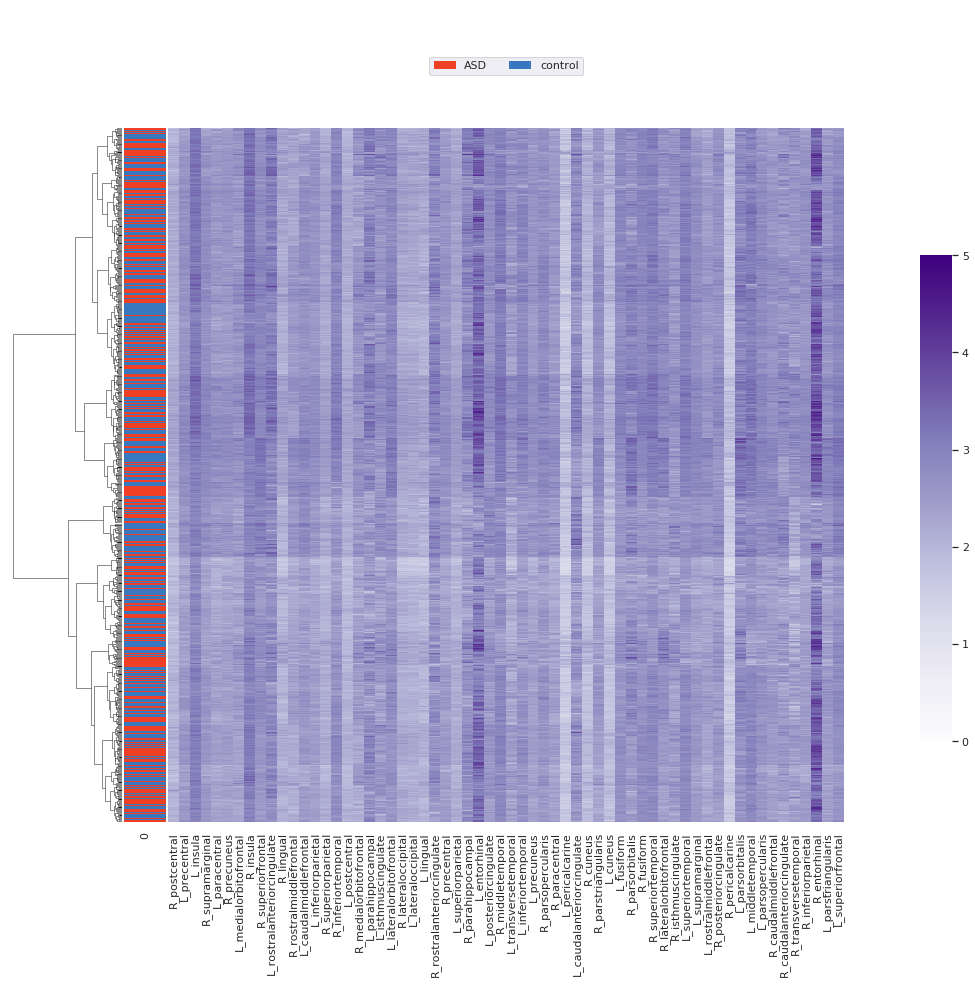

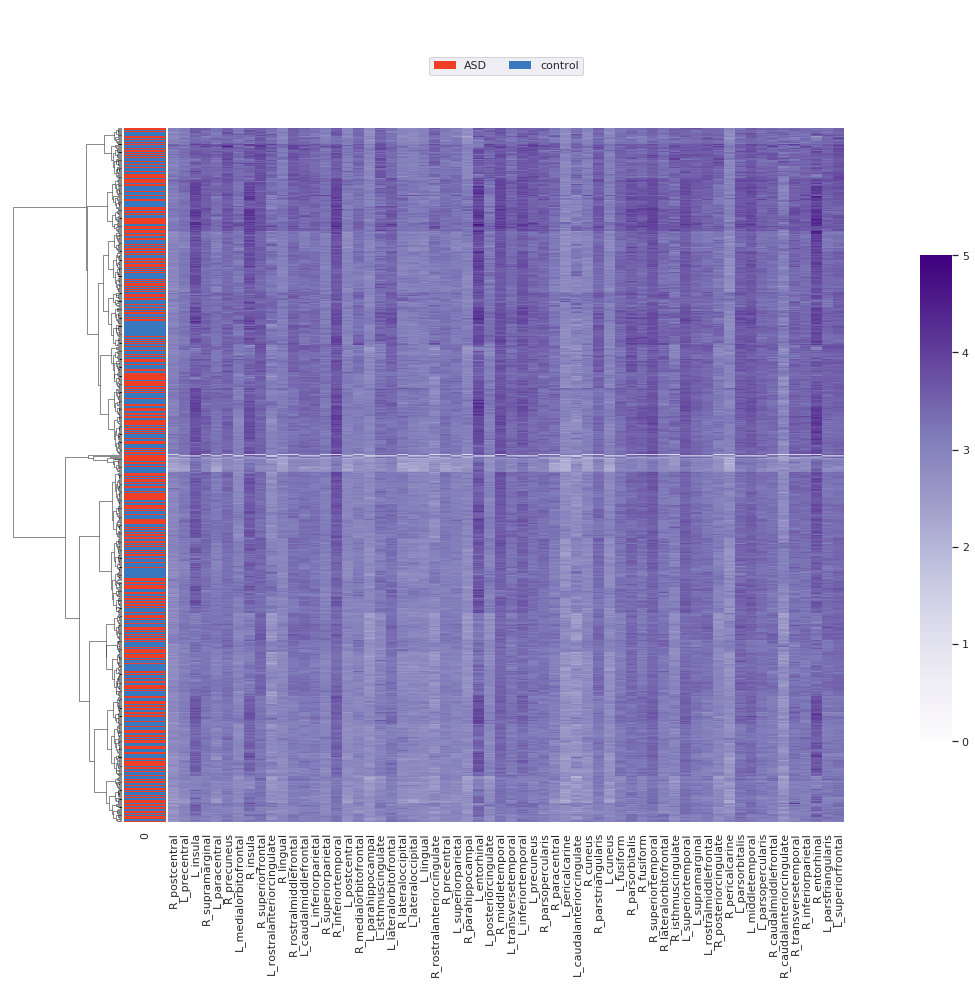

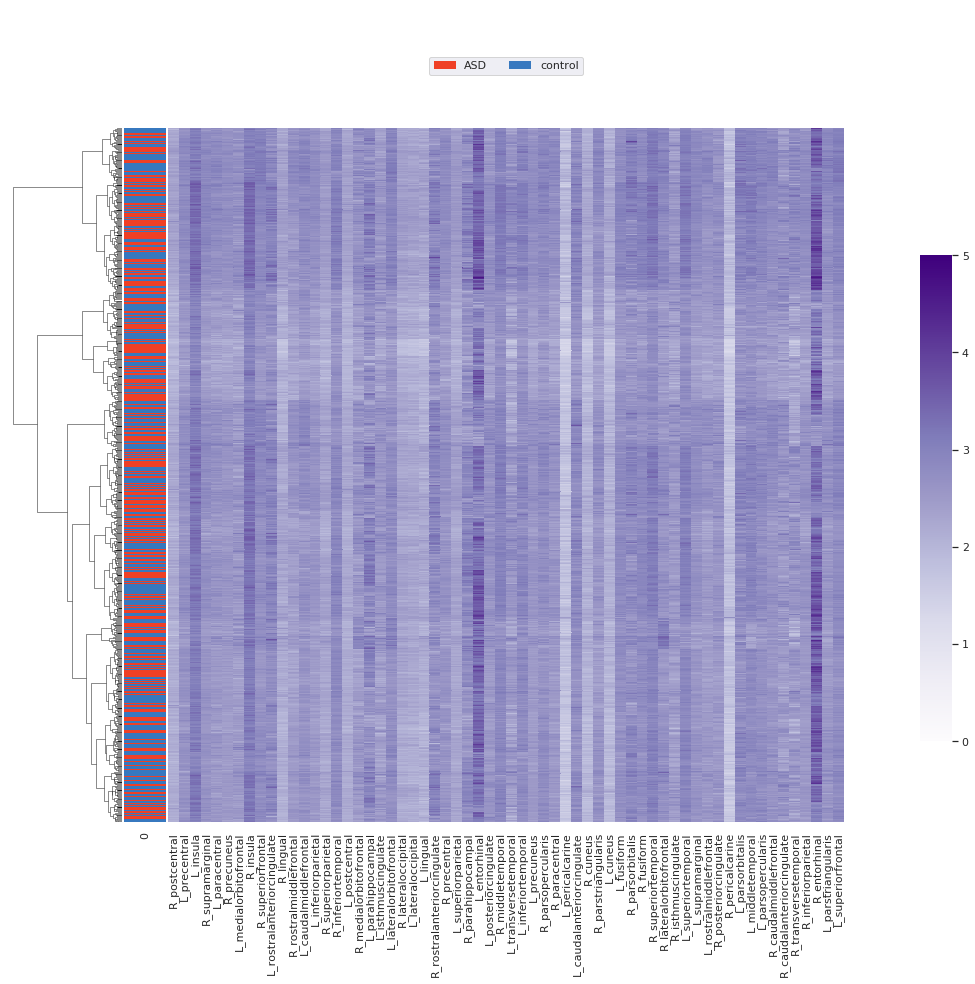

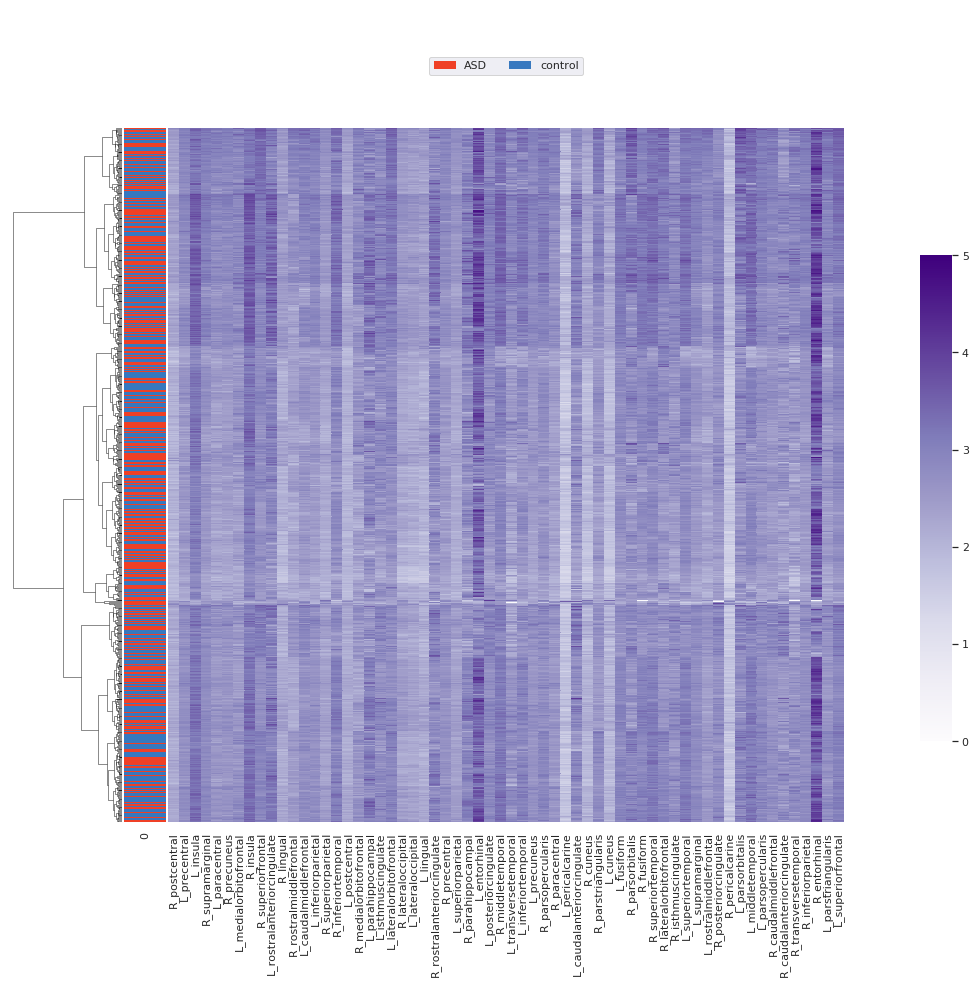

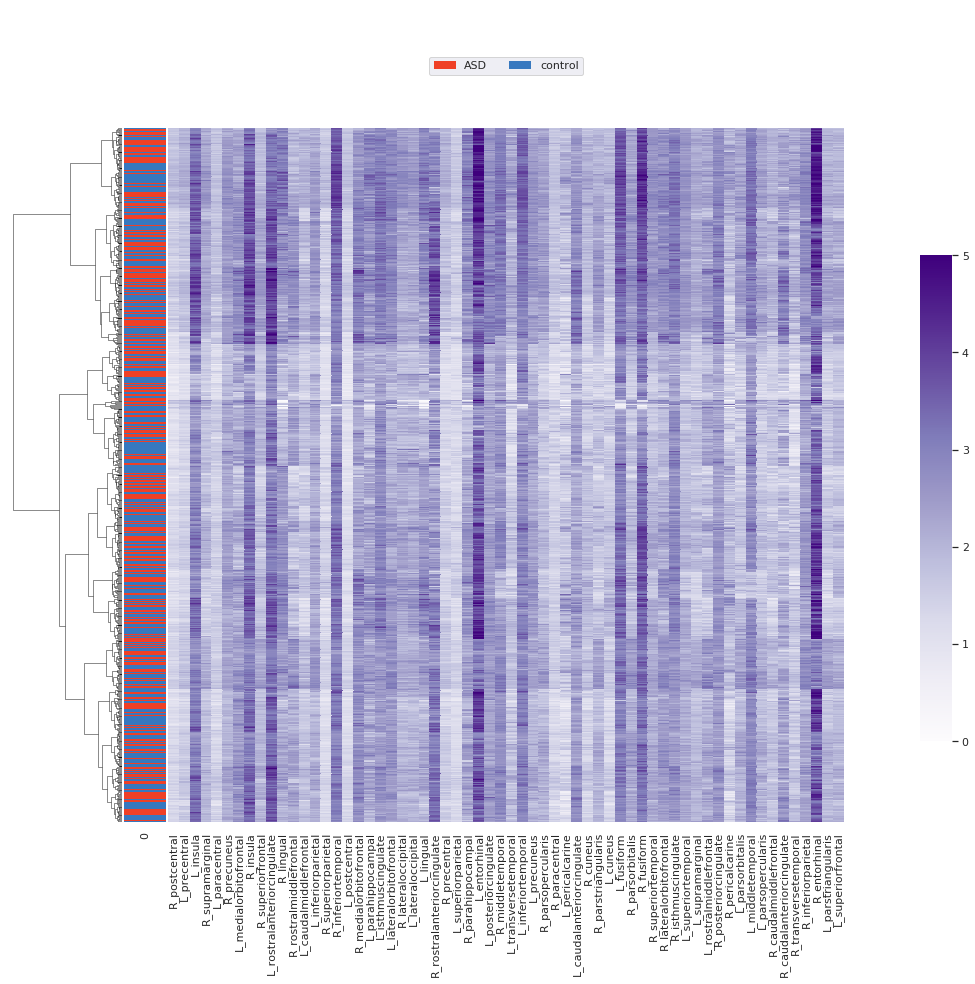

In [15]:
qc = 'No_QC'
master_df = master_df_dict[qc]

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# colors for the Dx visuals
colors = ["tomato","windows blue"]
Dx_palette = sns.xkcd_palette(colors)

sns.set(style="white")
sns.set(font_scale=1)

# Generate a custom diverging colormap
cmap = 'Purples' #sns.cubehelix_palette()#sns.diverging_palette(220, 10, as_cmap=True)

# create clustermap list for calculating overlap later
clustermap_dict = {} 

for pipe in master_df[data_label].unique():
    print('software: {}'.format(pipe))
    cluster_df = master_df[master_df[data_label]==pipe].copy().reset_index(drop=True)
    cluster_df['DX_GROUP'] = cluster_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    labels = cluster_df['DX_GROUP'].values
    lut = dict(zip(set(labels), Dx_palette))
    row_colors = pd.DataFrame(labels)[0].map(lut)

    
    g = sns.clustermap(cluster_df[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                       cmap=cmap,figsize=(15, 15),xticklabels=True, yticklabels=False,row_colors=row_colors,
                       vmin=0, vmax=5,)
    # Draw the legend bar for the classes                 
    for label in set(labels):
        g.ax_col_dendrogram.bar(0, 0, color=lut[label],label=label, linewidth=0)

    g.ax_col_dendrogram.legend(loc="center", ncol=2)
    g.cax.set_position([.97, .2, .03, .45])

    clustermap_dict[pipe] = g

In [18]:
# Pairwise subject cluster membership across software

n_cluster = 2
# Generate dataframe with subject-cluster membership for all software
# This needs to be aligned by SubjID
member_df_concat = pd.DataFrame()
for p, pipe in enumerate(clustermap_dict.keys()):
    member_df = get_cluster_membership(master_df[master_df[data_label]==pipe],data_label, clustermap_dict[pipe], n_cluster)
    if p == 0:
        member_df_concat = member_df
    else:
        member_df_concat = pd.merge(member_df_concat, member_df, on='SubjID',how='inner')
        
# Compare pipeline pairs for consistancy on subject-pairs memberships
# e.g. a pair of subjects that belongs to same cluster in pipeline A should ideally be in the same cluster for pipeline B
possible_pairs = list(itertools.combinations(clustermap_dict.keys(), 2))
table_df = pd.DataFrame(columns=software_list,index=software_list)

for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    m_col1 = 'membership_{}'.format(pipe1)
    m_col2 = 'membership_{}'.format(pipe2)
    c_membership1 = generate_pairwise_membership(member_df_concat,m_col1)
    c_membership2 = generate_pairwise_membership(member_df_concat,m_col2)
    pairwise_membership_consistancy = c_membership1.values == c_membership2.values
    n_unique_pairs = len(pairwise_membership_consistancy.flatten())/2-pairwise_membership_consistancy.shape[0]
    overlap = np.triu(pairwise_membership_consistancy).sum()/n_unique_pairs
    #print('\ncluster membership overlap: {} {:3.2f}'.format(pair, overlap))
    table_df.loc[pipe1,pipe2] = overlap.round(2)
    table_df.loc[pipe2,pipe1] = overlap.round(2)
    
print('')
table_df

software FS5.3, cluster sizes Counter({1: 414, 2: 364})
software ANTs, cluster sizes Counter({2: 535, 1: 243})
software FS6.0, cluster sizes Counter({2: 596, 1: 182})
software FS5.1, cluster sizes Counter({2: 533, 1: 245})
software CIVET, cluster sizes Counter({2: 412, 1: 366})



,ANTs,CIVET,FS5.1,FS5.3,FS6.0
ANTs,NaN,0.55,0.52,0.53,0.54
CIVET,0.55,NaN,0.52,0.54,0.52
FS5.1,0.52,0.52,NaN,0.64,0.77
FS5.3,0.53,0.54,0.64,NaN,0.58
FS6.0,0.54,0.52,0.77,0.58,NaN


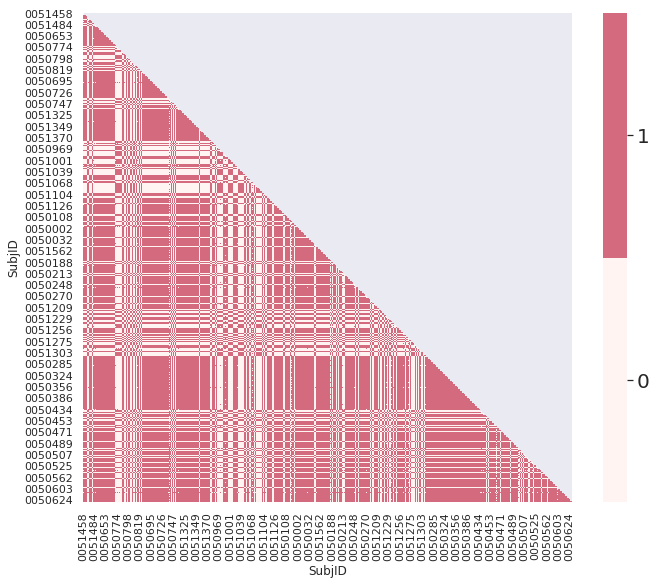

In [22]:
# Plot subject-pairs heatmap
m_col = 'membership_FS6.0'
c_membership = generate_pairwise_membership(member_df_concat,m_col)

# Generate a mask for the upper triangle
mask = np.zeros_like(c_membership, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(c_membership, mask=mask, cmap=cmap, square=True)
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])
    g.figure.axes[-1].tick_params(labelsize=20)

### CCA between cortical "representations"

In [15]:
from sklearn.cross_decomposition import CCA

sim_df_concat = pd.DataFrame()
for qc in master_df_dict.keys():
    master_df = master_df_dict[qc]
    for p, pair in enumerate(possible_pairs):
        pipe1 = pair[0]
        pipe2 = pair[1]
        X = master_df[master_df[data_label]==pipe1][common_roi_cols].values
        Y = master_df[master_df[data_label]==pipe2][common_roi_cols].values

        n_components = 10
        cca = CCA(n_components=n_components,scale=True)
        cca.fit(X, Y)
        X_c, Y_c = cca.transform(X, Y)
        corr_list = []
        for c in range(n_components):
            corr = np.corrcoef(X_c[:,c].flatten(),Y_c[:,c].flatten())[0,1]
            corr_list.append(np.round(corr,3))

        sim_df = pd.DataFrame(columns=['pair','cca_corr','qc_type'])
        sim_df.loc[p] = ['{}_{}'.format(pair[0],pair[1]),np.mean(corr_list),qc]

        sim_df_concat = sim_df_concat.append(sim_df)
        #print('{} {} correlation {}'.format(pipe1, pipe2, np.mean(corr_list)))
    
    

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


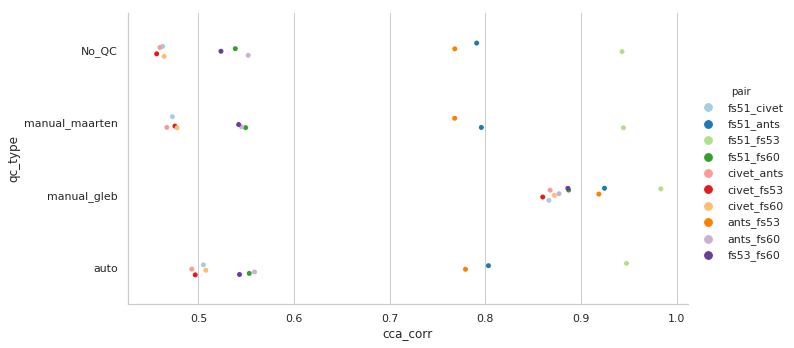

In [16]:
plot_df = sim_df_concat
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cca_corr',y='qc_type',hue='pair',palette='Paired',
                data=plot_df,aspect=2,height=5,kind='strip')

In [17]:
# See the effect of sample size from No_QC dataset
sim_df_concat_samp = pd.DataFrame()
n_sampx = np.arange(100,800,100)
n_components = 10
for p, pair in enumerate(possible_pairs):
    pipe1 = pair[0]
    pipe2 = pair[1]
    X = master_df[master_df[data_label]==pipe1][common_roi_cols].values
    Y = master_df[master_df[data_label]==pipe2][common_roi_cols].values

    for n in n_sampx:
        qc_type = 'RS_{}'.format(n)
        sample_rows = np.random.randint(len(X),size=n)
        X_samp = X[sample_rows]
        Y_samp = Y[sample_rows]
        cca = CCA(n_components=n_components,scale=True)
        cca.fit(X_samp, Y_samp)
        X_c, Y_c = cca.transform(X_samp, Y_samp)
        
        # compute correlation for multiple canonical components
        corr_list = []
        for c in range(n_components):
            corr = np.corrcoef(X_c[:,c].flatten(),Y_c[:,c].flatten())[0,1]
            corr_list.append(np.round(corr,3))
        
        sim_df = pd.DataFrame(columns=['pair','cca_corr','qc_type'])
        sim_df.loc[p] = ['{}_{}'.format(pair[0],pair[1]),np.mean(corr_list),qc_type]

        sim_df_concat_samp = sim_df_concat_samp.append(sim_df)
        #print('{} {} correlation {:4.2f}'.format(pipe1, pipe2, np.mean(corr_list)))

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-

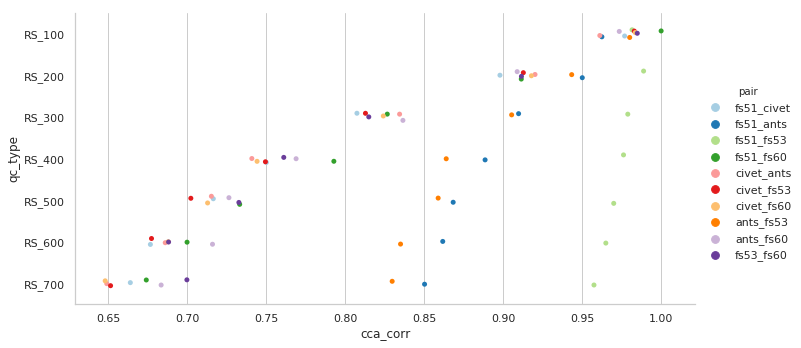

In [18]:
plot_df = sim_df_concat_samp #.sort_values(by='corr')
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cca_corr',y='qc_type',hue='pair',palette='Paired',
                data=plot_df,aspect=2,height=5,kind='strip')

### Compare ML performance 

In [27]:
ml_results_dir = results_dir + 'ml/'

# Start time
start = time.time()

save_perf = False
rank_features = False
model_type = 'regression'
cv_type = 'shuffle_split'

ml_perf_concat = pd.DataFrame()
feature_rank_df_concat = pd.DataFrame()

for qc in qc_list[0:1]:
    master_df = master_df_dict[qc]
    roi_cols = common_roi_cols

    if model_type.lower() == 'regression':
        for dx_grp in [0,1]:
            print('\nUsing qc {}, and Dx {}'.format(qc,dx_grp))
            ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
            outcome_col = 'AGE_AT_SCAN'
            covar_continuous_cols = []
            covar_cat_cols = ['SEX','SITE_ID'] 
            model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
            ml_perf,perf_pval_dict,feature_rank_df = computeSoftwareMLModels(ml_master_df,data_label,roi_cols,covar_continuous_cols,
                                                                             covar_cat_cols,outcome_col,model_type,model,
                                                                             rank_features,n_jobs=-1)

            ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
            ml_perf['qc'] = np.tile(qc,len(ml_perf))
            ml_perf_concat = ml_perf_concat.append(ml_perf)
            
            feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
            feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
            feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
    else: 
        print('\nUsing qc {}'.format(qc))
        ml_master_df = master_df

        outcome_col = 'DX_GROUP'
        covar_continuous_cols = ['AGE_AT_SCAN']
        covar_cat_cols = ['SEX','SITE_ID'] 
        #model = svm.SVC(kernel='linear')
        model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

        ml_perf,perf_pval_dict,feature_rank_df = computeSoftwareMLModels(ml_master_df,roi_cols,covar_continuous_cols,covar_cat_cols,
                                                     outcome_col,model_type,model,n_jobs=-1)

        ml_perf['qc'] = np.tile(qc,len(ml_perf))
        ml_perf_concat = ml_perf_concat.append(ml_perf)
        
        feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
        feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
        feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
if save_perf:
    save_path = '{}Software_DKT_ml_feature_imp_{}_{}_{}.pkl'.format(ml_results_dir,outcome_col,model_type,cv_type)
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    save_df = feature_rank_df_concat[(feature_rank_df_concat['predictor'].isin(roi_cols))]
    save_df = save_df.rename(columns={'predictor':'roi'})
    save_df.to_pickle(save_path)
        
    
end = time.time()
print('Run duration:')
print((end - start)/60.0)


Using qc No_QC, and Dx 0
Running ML classifer on 5 software
software FS5.3
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-31.457, sd:8.912
software CIVET
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-42.683, sd:10.700
software FS6.0
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-37.303, sd:13.282
software FS5.1
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_m

{'FS5.3': 0.09090909090909091, 'ANTs': 0.09090909090909091, 'FS6.0': 0.09090909090909091, 'FS5.1': 0.09090909090909091, 'CIVET': 0.09090909090909091}


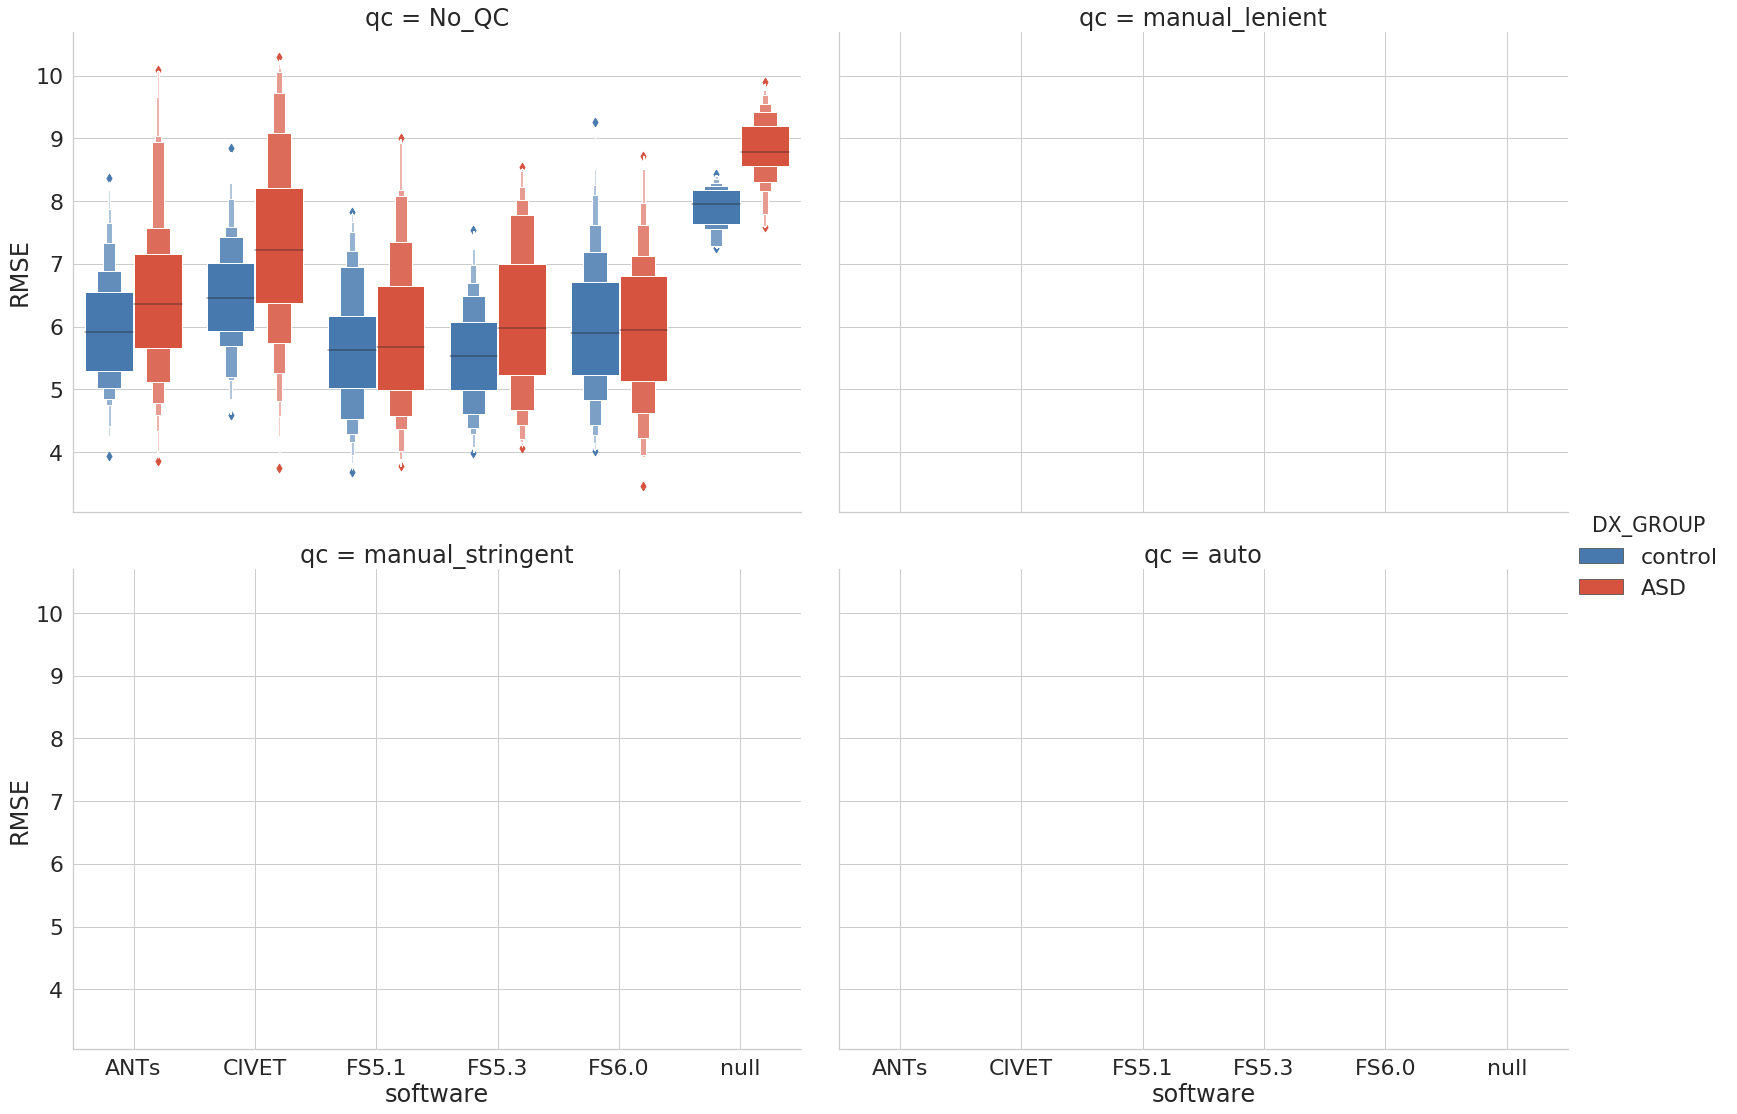

In [28]:
# plot ML performance
print(perf_pval_dict)
x_order = software_list + ['null']
col_order = qc_list 
colors = ["windows blue", "tomato", "greyish", "faded green", "dusty purple","dark grey"]
palette = sns.xkcd_palette(colors) #'Paired' #sns.xkcd_palette(colors)
sns.set(font_scale=2)
    
plot_df = ml_perf_concat.copy()

if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(-1*plot_df['neg_mean_squared_error'])
    plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    
    with sns.axes_style("whitegrid"): 
        g = sns.catplot(y='RMSE',x=data_label, hue='DX_GROUP', kind='boxen',col='qc',col_order=col_order,col_wrap=2,
                        order=x_order,palette=palette,height=8, aspect=1.4,legend=True,data=plot_df)
        #plt.legend(loc='upper right')
else:
    with sns.axes_style("white"): 
        g = sns.catplot(y='roc_auc',x=data_label, hue='DX_GROUP', kind='boxen',data=plot_df,col='qc',col_order=col_order,
                        order=x_order,palette=palette,height=20, aspect=1.1,legend=False)
#         plt.legend(loc='upper right')

### Get ML based feature importance
- verfied rerunning stability. For a sprcified random_state in CV, RFECV returns identical output.

In [137]:
feature_count_df = pd.DataFrame(columns=['count',data_label,'DX_GROUP','qc'])
i = 0
roi_cols = common_roi_cols
for pipe in ml_master_df[data_label].unique():
    for qc in feature_rank_df_concat['qc'].unique():
        for dx in [0,1]:
            n_feat = len(feature_rank_df_concat[(feature_rank_df_concat[data_label] == pipe) &                              
                                                (feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)])
            feature_count_df.loc[i] = [n_feat,pipe,dx,qc]
            i+=1
            print('Pipeline {}, n_roi {}, qc {}, dx {}, n_feat {}\n'.format(pipe,len(roi_cols),qc,dx,n_feat))

Pipeline FS5.3, n_roi 62, qc No_QC, dx 0, n_feat 5

Pipeline FS5.3, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline FS5.1, n_roi 62, qc No_QC, dx 0, n_feat 11

Pipeline FS5.1, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline ANTs, n_roi 62, qc No_QC, dx 0, n_feat 13

Pipeline ANTs, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline CIVET, n_roi 62, qc No_QC, dx 0, n_feat 18

Pipeline CIVET, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline FS6.0, n_roi 62, qc No_QC, dx 0, n_feat 19

Pipeline FS6.0, n_roi 62, qc No_QC, dx 1, n_feat 0



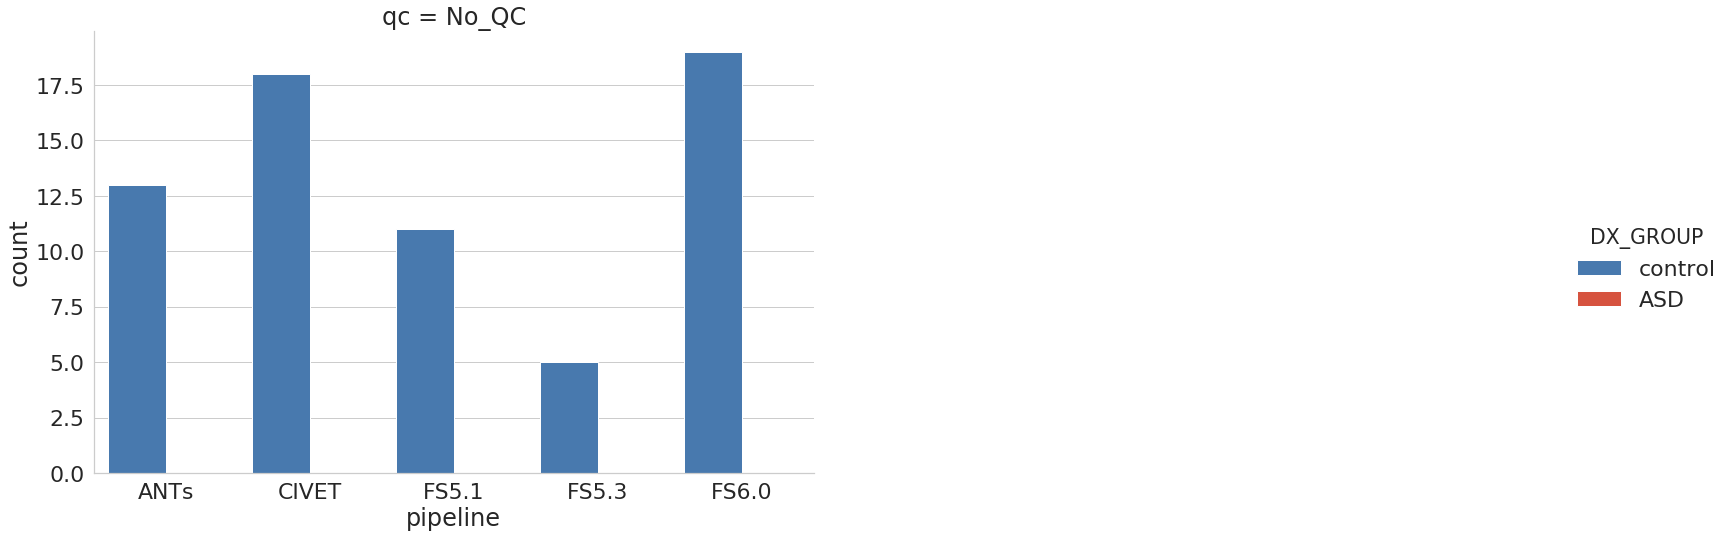

In [138]:
plot_df = feature_count_df
plot_df = plot_df #[plot_df['qc']=='No_QC']
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
sns.set(font_scale=2)

with sns.axes_style("whitegrid"): 
    x_order = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0']
    g = sns.catplot(y='count',x=data_label,hue='DX_GROUP', col='qc', col_wrap=2,
                    kind='bar', palette=palette, height=8, aspect=1.4, data=plot_df, order=x_order)

In [82]:
feature_rank_df_concat[(feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)]

,predictor,rank,grid_scores,pipeline,DX_GROUP,qc
0,L_lingual,1,-50.660181,FS6.0,1,No_QC
2,L_precuneus,1,-44.171878,FS6.0,1,No_QC
4,R_superiortemporal,1,-40.987022,FS6.0,1,No_QC
6,R_insula,1,-40.380302,FS6.0,1,No_QC
8,R_posteriorcingulate,1,-39.509839,FS6.0,1,No_QC
10,L_superiorfrontal,1,-38.761322,FS6.0,1,No_QC
14,R_precuneus,1,-38.550894,FS6.0,1,No_QC
16,R_isthmuscingulate,1,-38.430930,FS6.0,1,No_QC
22,L_posteriorcingulate,1,-38.542823,FS6.0,1,No_QC
27,R_lingual,1,-38.530277,FS6.0,1,No_QC



### Compare statsmodels performance 
- statmodels performance plots are generate using "generate_plots" notebook

In [29]:
save_sm_perf = False
sm_results_dir = results_dir + 'sm/'

model_type = 'ols'
if model_type == 'ols':
    covar_cols = [('DX_GROUP','cat'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('roi','continuous')
    signific_col = ('AGE_AT_SCAN','continuous')
    stat_model = 'ols' 
elif model_type == 'logit':
    covar_cols = [('AGE_AT_SCAN','continuous'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('DX_GROUP','cat') 
    signific_col = ('roi','continuous') 
    stat_model = 'logit' 
else:
    print('unknown stat model')

roi_cols = common_roi_cols

for qc in qc_list:
    print('QC type {}'.format(qc))
    master_df = master_df_dict[qc]
    sm_perf = computeSoftwareStatsModels(master_df,data_label,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    filtered_subs = master_df[subject_ID_col].unique()
    if save_sm_perf:
        save_path = '{}Software_DKT_sm_perf_{}_{}_{}_QC_{}_N_{}.pkl'.format(sm_results_dir,outcome_col[0],signific_col[0],
                                                                         stat_model,qc,len(filtered_subs))
        print('Saving sm_perf dictionary at \n{}'.format(save_path))
        sm_perf.to_pickle(save_path)


QC type No_QC
Running 62 mass-univariate ols statsmodels on 5 software
software FS5.3
Example statsmodel run:
 L_superiorfrontal ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef      t_val         p_val    p_val_corr  \
5              R_precuneus -0.014579 -17.045680  2.188130e-55  1.356641e-53   
33             L_precuneus -0.014381 -16.241639  4.070845e-51  1.261962e-49   
13      L_inferiorparietal -0.013833 -15.145575  1.852468e-45  3.315357e-44   
61       L_superiorfrontal -0.015178 -15.133255  2.138940e-45  3.315357e-44   
11  R_rostralmiddlefrontal -0.013682 -14.465810  4.700857e-42  5.829062e-41   
8        R_superiorfrontal -0.014400 -14.402277  9.682038e-42  1.000477e-40   
58      R_inferiorparietal -0.012879 -14.202542  9.276635e-41  8.216448e-40   
14      R_superiorparietal -0.012008 -14.066679  4.270769e-40  3.309846e-39   
49  L_rostralmiddlefrontal -0.013900 -13.751978  1.419974e-38  9.782043e-38   
48

Example statsmodel run:
 L_superiorfrontal ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef      t_val         p_val    p_val_corr  \
5              R_precuneus -0.012509 -17.252540  3.643703e-56  2.259096e-54   
61       L_superiorfrontal -0.013558 -16.848335  5.091866e-54  1.578478e-52   
8        R_superiorfrontal -0.012843 -16.332300  2.591030e-51  5.354795e-50   
13      L_inferiorparietal -0.012413 -15.995398  1.444780e-49  2.239409e-48   
33             L_precuneus -0.012305 -15.732834  3.227495e-48  4.002094e-47   
49  L_rostralmiddlefrontal -0.012670 -14.987393  1.899119e-44  1.962422e-43   
14      R_superiorparietal -0.011552 -14.886719  6.032279e-44  5.342876e-43   
58      R_inferiorparietal -0.011029 -14.581457  1.956537e-42  1.516316e-41   
26      L_superiorparietal -0.011173 -14.534300  3.337412e-42  2.299106e-41   
11  R_rostralmiddlefrontal -0.011637 -14.393988  1.625836e-41  1.008018e-40   

   softw

Example statsmodel run:
 L_superiorfrontal ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef      t_val         p_val    p_val_corr  \
5              R_precuneus -0.020066 -15.406260  5.279969e-46  3.273581e-44   
33             L_precuneus -0.020520 -15.186575  6.395788e-45  1.982694e-43   
13      L_inferiorparietal -0.020810 -14.951874  9.015424e-44  1.863188e-42   
49  L_rostralmiddlefrontal -0.022646 -14.734783  1.023487e-42  1.586405e-41   
11  R_rostralmiddlefrontal -0.020420 -14.149896  6.512152e-40  8.075069e-39   
58      R_inferiorparietal -0.019551 -14.055840  1.815781e-39  1.876307e-38   
14      R_superiorparietal -0.017953 -13.739721  5.548074e-38  4.914008e-37   
20  L_lateralorbitofrontal -0.022155 -13.655422  1.371080e-37  1.062587e-36   
45  R_lateralorbitofrontal -0.022486 -13.155971  2.736567e-35  1.885191e-34   
26      L_superiorparietal -0.016704 -12.882426  4.743601e-34  2.941033e-33   

   softw